# Text classification

## Getting the data

For this notebook you need to have some NLTK `movie reviews` data installed.  First make sure you have nltk installed as a Python module (or the first line in the code block below won't work).  Then install the data as follows:

```
import nltk
nltk.download()
```

This pops up a separate window.  It has several tabs, one of them labeled `corpora`.  Select that tab and you will see a long alphabetically ordered list of all the corpora `NLTK` supplies.  Scroll down and select `Movie Reviews` and click on `Download`.  This will install that data on your machine, and all the code in this notebook
should work.

## Peliminaries:  Code for getting data and extracting features

In [2]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/gawron/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:

def unigram_features (words):
    """ 
    This is the simplest possible feature representation of a document.
    
    Each word is a feature.
    """
    return dict((word, True) for word in words)


def extract_features (corpus, file_ids, cls, feature_extractor=unigram_features):
    """
    Turn a set of files all belonging to one class into a list
    of (feature dictionary, cls) pairs, to be used in testing or training
    a classifier.
    """
    return [(feature_extractor(corpus.words(i)), cls) for i in file_ids]


def get_words_from_corpus (corpus, file_ids):

    for file_id in file_id|s:
        words = corpus.words(file_id)
        for word in words:
            yield word



## Loading the data

In line 3  of the next cell, we import the NLTK Bo Pang and Lillian Lee's movie reviews corpus.  Line 5 prints some information about the corpus properties; these appear in the output cell.  

In [ ]:
# Using a corpus of movie review data
# 2000 positive and negative reviews, evenly balanced.
from nltk.corpus import movie_reviews as mr

# If you want to read the corpus collectors' introduction to
# this corpus, uncomment the next line.
#print mr.readme()

The movie review data is packaged up as an NLTK corpus, which 
gives us access to a number of tools for text handling.  The simplest
is that we have two views of the movie review data, word by word and character by character.

The character by character view uses the `raw` method, which returns all the data wiht no argument, or just the data from asingle file with a fileid argument:    

In [ ]:
data = dict(pos = mr.fileids('pos'),
            neg = mr.fileids('neg'))
print mr.raw(data['pos'][0])[:100]

films adapted from comic books have had plenty of success , whether they're about superheroes ( batm


The word by word character view uses the `words` method::

In [ ]:
print mr.words(data['pos'][0])[:10]

[u'films', u'adapted', u'from', u'comic', u'books', u'have', u'had', u'plenty', u'of', u'success']


We will be using the word by word view.

## Training a classifier

In [ ]:

from nltk.corpus import movie_reviews as mr

data = dict(pos = mr.fileids('pos'),
            neg = mr.fileids('neg'))

#######################################################################
#
#  Dividing up the data
#######################################################################

# Use 90% of the data for training
test_start_index = 900

neg_training = extract_features(mr, data['neg'][:test_start_index], 'neg',
                                feature_extractor=unigram_features)

# Use 10% for testing the classifier on unseen data.
neg_test = extract_features(mr, data['neg'][test_start_index:], 'neg',
                                feature_extractor=unigram_features)

pos_training = extract_features(mr, data['pos'][:test_start_index],'pos',
                                feature_extractor=unigram_features)

pos_test = extract_features(mr, data['pos'][test_start_index:],'pos',
                                feature_extractor=unigram_features)

train_set = pos_training + neg_training

test_set = pos_test + neg_test

Line 2 imports the movie review data from NLTK, and lines 4 and 5 store the two halves of the corpus in a dictionary (positive and negative reviews, 1000 of each).   The commands on 
the next few lines extract features from the data files, sorting them in pos and negative training and positive and negative test sets.  The training set is 90% of the the data; the test set is 10% of the data.  The feature extractor used is `unigram_features`, the simple feature extractor defined in the first code cell of this notebook.  This feature extractor just uses every word that appears in a document as a feature.  Finally in line 31 the positive and negative training data is combined into a single training set, and in line 36, a Naive Bayes (NB) classifier is trained.

In the next cell, we look at an example representation of a movie review.  It is basically just a set, telling us what words occurred in the review, but not how many times they
occurred.  In terms of a Python data structure, it's a dictionary whose keys are the words
in the document, and whose values are all `True.`  We're not bothering to represent the words
that don't occur in the document, so there are no keys whose value are is `False`.

In [ ]:
test_set[0]

({u'!': True,
  u'%': True,
  u"'": True,
  u'(': True,
  u')': True,
  u',': True,
  u'.': True,
  u'100': True,
  u'13': True,
  u'1912': True,
  u'3': True,
  u':': True,
  u'?': True,
  u'a': True,
  u'about': True,
  u'above': True,
  u'accomplished': True,
  u'accuracy': True,
  u'achieve': True,
  u'across': True,
  u'acting': True,
  u'actually': True,
  u'adding': True,
  u'adds': True,
  u'admirably': True,
  u'admired': True,
  u'aft': True,
  u'ago': True,
  u'aims': True,
  u'aliens': True,
  u'all': True,
  u'almost': True,
  u'alone': True,
  u'already': True,
  u'also': True,
  u'although': True,
  u'amaze': True,
  u'amazed': True,
  u'america': True,
  u'an': True,
  u'and': True,
  u'anew': True,
  u'any': True,
  u'anything': True,
  u'are': True,
  u'aren': True,
  u'as': True,
  u'ask': True,
  u'astonishing': True,
  u'at': True,
  u'atlantic': True,
  u'attention': True,
  u'backdrop': True,
  u'be': True,
  u'beautifully': True,
  u'because': True,
  u'been': T

In [ ]:
len(data['neg'])

1000

We have now split the data into two unequal haves, each with positive and negative examples, and called the larger half `train_set` and the smaller half `test_set`.

Next we **train** the classifier by giving it the training set.

In [ ]:
# Use a Naive Bayes Classifier
from nltk.classify import NaiveBayesClassifier

#  Train a classifier on our training data.
classifier = NaiveBayesClassifier.train(train_set)

## A demonstration

In the next code cell, we demonstrate what the classifier does on the first reviews in the the positive and negative training set.  The output window shows that both reviews are correctly classified by the NB classifier we just trained.

First, we pick a review.

In [ ]:
def get_review_text (clf,file_id,start=0,end=None):
    words = list(mr.words(data[clf][file_id]))
    return ' '.join(words[start:end])

print get_review_text('pos',0,end=95)

print '     . . . . . . '

print get_review_text('pos',0,start=-190)

films adapted from comic books have had plenty of success , whether they ' re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there ' s never really been a comic book like from hell before . for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid ' 80s with a 12 - part series called the watchmen .
     . . . . . . 
, but cinematographer peter deming ( don ' t say a word ) ably captures the dreariness of victorian - era london and helped make the flashy killing scenes remind me of the crazy flashbacks in twin peaks , even though the violence in the film pales in comparison to that in the black - and - white comic . oscar winner martin childs ' ( shakespeare in love ) production design turns the original prague surroundings into one creepy place . even the acting in from hell is solid , with the dreamy depp turning in a typically strong perfor

Reading this makes it clear why movie reviews are hard, especially with the approach we're taking;  each word is treated as an independent feature whose presence increases or decreases the probability the review is positive. Overall it's positive review but it's not easy finding single words that might give us good evidence of that,
and there are words that probably point the other way as well:

```
Pos         Neg
-----------------
ably      dreariness
flashy    violence
surprise  bad
strong    creepy
deftly    cringed
good
oscar
winner
great
```

Nevertheless, let's trry this out and see how we do.

In [ ]:
predicted_label0 = classifier.classify(pos_test[0][0])

print 'Predicted: %s Actual: pos' % (predicted_label0,)

Predicted: pos Actual: pos


We got it right!  Let's try a negative review.

In [ ]:
predicted_label1 = classifier.classify(neg_test[0][0])

print 'Predicted: %s Actual: neg' % (predicted_label1,)

# To see the the feature dictionary passed in to the classifier,
# uncomment the next line
#pos_test[0][0]

Predicted: neg Actual: neg


Right again!

Let's try the examples we cooked up before.  We need go to from
a string like `"Inception is the best movie ever"` to a feature dictionary
and pass that to the classifier.


In [ ]:
classifier.classify(unigram_features('Inception is the best movie ever'.split()))

'pos'

In [ ]:
classifier.classify(unigram_features("I don't know how anyone could sit through Inception".split()))

'neg'

Interesting.  We may get some insight on this one below.

## Most informative features

Heres what our classifier learned.  These are the features for which the ratio of the positive to negative probability (or vice versa) is the highest.

In [ ]:

classifier.show_most_informative_features()


Most Informative Features
             outstanding = True              pos : neg    =     15.6 : 1.0
               ludicrous = True              neg : pos    =     14.2 : 1.0
              astounding = True              pos : neg    =     12.3 : 1.0
                  avoids = True              pos : neg    =     12.3 : 1.0
                 idiotic = True              neg : pos    =     11.8 : 1.0
               atrocious = True              neg : pos    =     11.7 : 1.0
             fascination = True              pos : neg    =     11.0 : 1.0
                 offbeat = True              pos : neg    =     11.0 : 1.0
               animators = True              pos : neg    =     10.3 : 1.0
                  symbol = True              pos : neg    =     10.3 : 1.0


We have more features showing up as good indicators of  favorable review, and this is an indicator of a problem with our classifier.  As we'll see below.  the classifier is a little too reluctant to classify reviews as negative on the test set.  This suggests that reliable negative indicators are not that common.

## Serious testing



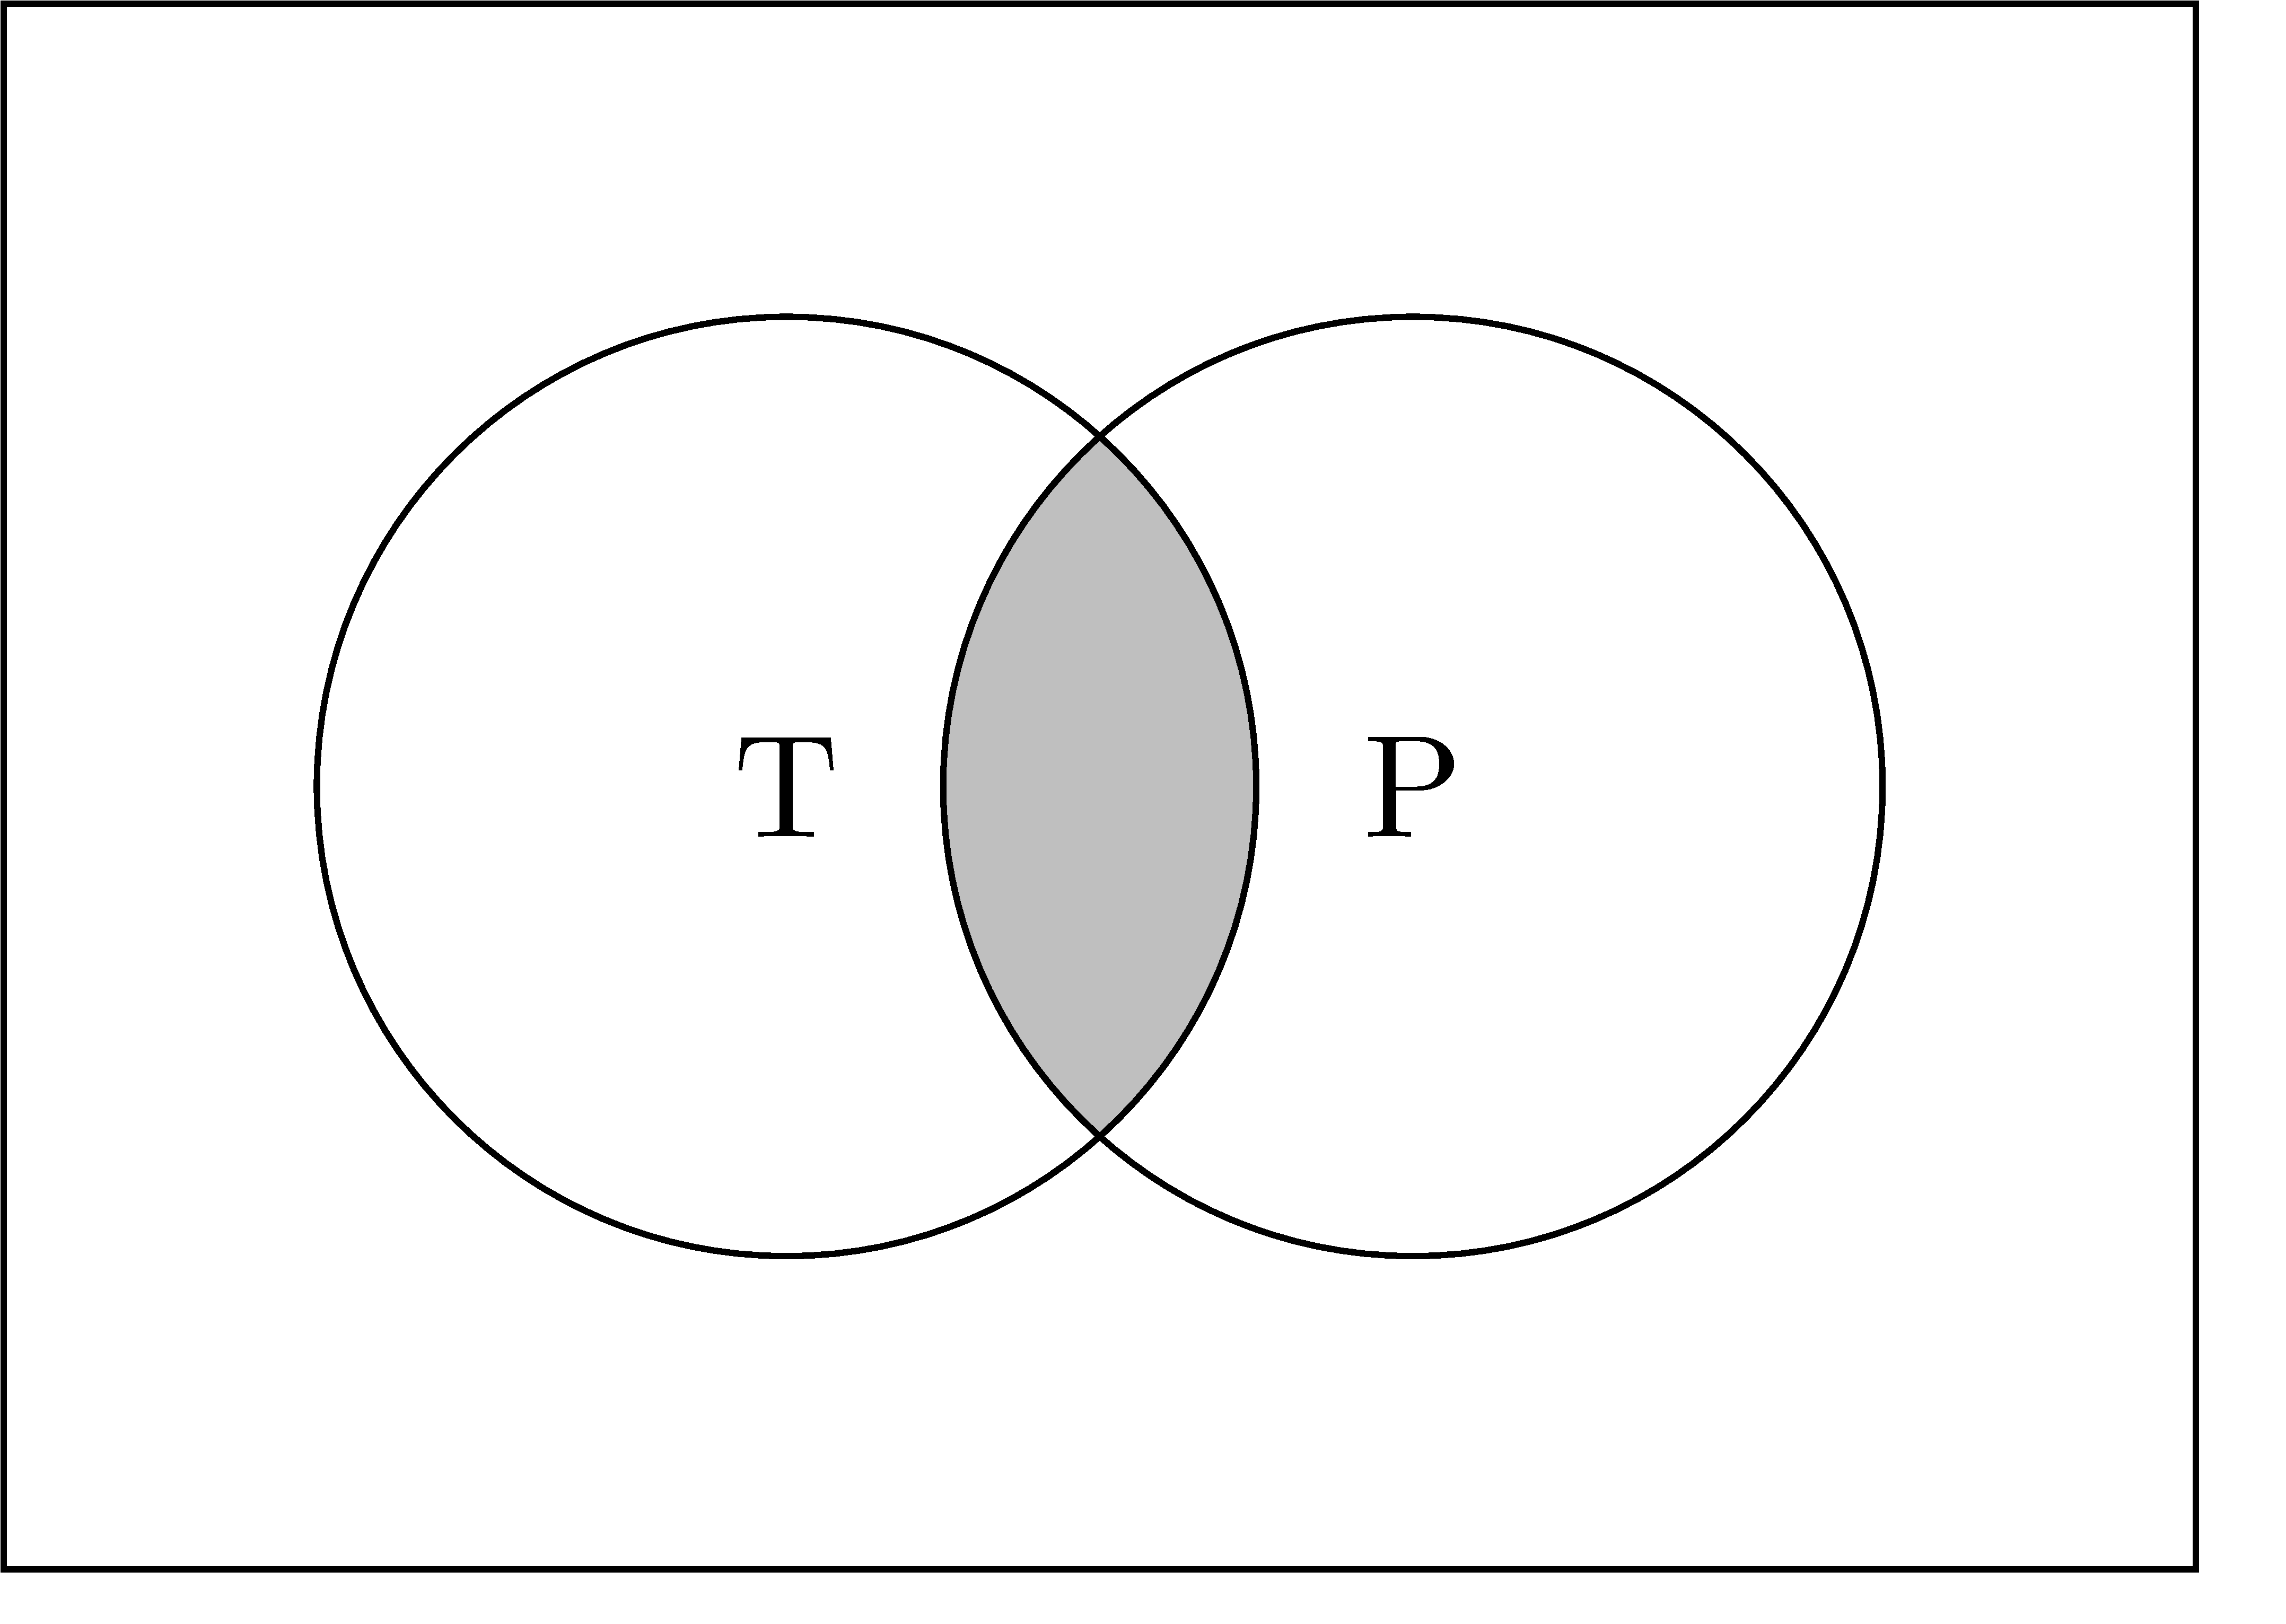


The image above represents a typical classification situation.  The circle labeled T contains the true instances of the class (the set of favorable movie reviews).  The circle labeled P represents the **system positives**, the reviews the classifier has **called** favorable.  The two circles divide the picture into four regions.  The overlap of the two circles represents the favorable reviews the classifier got right, the **true positives**.  The area outside both circles represents another set the classifier got right, unfavorable reviews that were classified as unfavorable.  These are **true negatives**.  The two areas inside the circles but outside the overlap represent cases the system got wrong, P but not T, unfavorable reviews that were mistakenly classified as favorable (**false positives**), and T but not P,favorable reviews that were mistakenly classified as unfavorable (**false negatives**).

The next cell defines some code for evaluating classifier output using these four classes of system outcome.   The evaluation metrics defined are **precision, recall, and accuracy**.  Let N be the size of the dataset, $tp$ and $fp$ be true and false positive respectively and $tn$ and $fn$ be true and false negatives respective.  
 Precision is the percentage of true positives out all positive guesses the system made $\left(\frac{tp}{tp + fp}\right)$, in other words the ratio of the size of the overlap of the two circles to the size of the P circle.
Precison = the proportion of the positives that are correct.  
 
 Recall is  the ratio of the size of the overlap of the two circles to the size of the T circle, in other words the percentage of true positives out of all favorable reviews $\left(\frac{tp}{tp + fn}\right)$.

Accuracy is the percentage of correct answers out of the total set of answers $\left(\frac{tp+tn}{N}\right)$, in other words the ration

In [ ]:
from sklearn.metrics import precision_score, recall_score,accuracy_score

def do_evaluation (pairs, pos_label='pos', verbose=True):
    predicted, actual = zip(*pairs)
    (precision, recall,accuracy) = (precision_score(actual,predicted,pos_label=pos_label), 
                                    recall_score(actual,predicted,pos_label=pos_label),
                                    accuracy_score(actual,predicted))
    if verbose:
        print_results(precision, recall, accuracy, pos_label)
    return (precision, recall,accuracy)

def print_results (precision, recall, accuracy, pos_label):
    banner =  'Evaluation with pos label = %s' % pos_label
    print()
    print (banner)
    print ('=' * len(banner))
    print ('{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))


The code in the next cell actually tests our NB classifier on the entire test set and prints out the result.  Note that precision and recall give different results depending on which  class we think of ourselves as detecting (which class we think of as "positive").  Using the same labels for the region in the diagram as before,  recall for detecting unfavorable reviews is $\left(\frac{tn}{tn + fp}\right)$.  This is sometimes called **specificity**; precision at detecting unfavorable reviews  is $\left(\frac{tn}{tn + fn}\right)$, and is sometimes called. **negative predictive value**.

We show specificity and negative predictive value below (under "pos lebvale = neg").  The low specificity value  shows that our classifier actually misses a number of  unfavorable reviews because it misclassifies them as favorable (recall of favorable high, recall of unfavorable low).  In sum, its high recall number when `pos_cls = pos` needs to be taken with a grain of salt, because it achieves high recall by guessing positive a lot of the time.
In fact, it guesses positive 74% of the time, even though it was trained on data that was 50% positive and 50% negative.

This fact make it even more interesting that we correctly classified

```
I don't know how anyone could sit through Inception.
```

as negative.  In fact it turns out 'sit' is just a pretty good indicator of a negative review. It occurs 79 times in our set of 1000 negative reviews, quite often followed by 'through'.  This tells us something important.  Our intuitions aren't always good at finding good features.

So why does our classifier guess positive so often?  Well, probably because it had more success finding strong positive indicators than it did finding strong negative indicators, as our glance at the most informative features suggested.  This is something we might want to worry about as we design good classifiers.

In [ ]:
pairs = [(classifier.classify(example), actual)
            for (example, actual) in test_set]

do_evaluation (pairs)
pos_guesses = [p for (p,a) in pairs if p=='pos']
pos_actual = [a for (p,a) in pairs if a=='pos']
do_evaluation (pairs, pos_label='neg')
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(pairs))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(pairs))
# to see the actual pairs that came out of the test uncomment the next line
#pairs


Evaluation with pos label = pos
Precision  65.5
Recall     97.0
Accuracy   73.0

Evaluation with pos label = neg
Precision  94.2
Recall     49.0
Accuracy   73.0
Note that 74.0% of our classifier guesses were positive
While 50.0% of the reviews were actually positive


## SVM Classifier

We'll also try a **Support Vector Machine** classifier on the movie review data, both to illustrate a different learning model and to illustrate a somewhat different set of machine learning tools than those in NLTK.

Since we're not taking advantage of NLTK's code for handling its own data this time, the script below is a little closer to what you would actually end up doing with "raw" labeled data that you had downloaded from the web or some other data source. It still skips an important step called **Tokenization** which we defer for now, because this data has already been tokenized.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

import os.path

def add_data_from_files (file_list,data_list):
    for f in file_list:
        with open(f,'r') as fh:
            data_list.append(fh.read())

home = os.getenv('HOME')  
# This is where MY NLTK data is.  Yours should be in a similar place relative
# to what your machine thinks is HOME.
data_dir = os.path.join(home,'nltk_data/corpora/movie_reviews/')

clses = ['pos','neg']

#  The data is in the data_dir, sorted into subdirectories, one for each class.
data_dirs = [os.path.join(data_dir,cls) for cls in clses]
#  We use a somewhat more traditional feature weights, called TFIDF weights
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                    stop_words='english')

# We're going to compute 4 lists training data and labels, test data a nd labels
train_labels = []
test_labels = []

train_data = []
test_data = []
training_proportion = (9,10)
for i,cls  in enumerate(clses):
    d_dir = data_dirs[i]
    os.chdir(d_dir)
    cls_files = os.listdir(d_dir)
    num_cls_files = len(cls_files)
    training_index = (training_proportion[0] *(num_cls_files/training_proportion[1]))
    train_labels.extend(cls for f in cls_files[:training_index])
    test_labels.extend(cls for f in cls_files[training_index:])
    add_data_from_files (cls_files[:training_index],train_data)
    add_data_from_files (cls_files[training_index:],test_data)

# Now with data set represented as a list of strings (one from each file),
# extract the TFIDF features
train_features = vectorizer.fit_transform(train_data)

#  We extract features from the test data using the same vectorizer
#  trained on training data. The TFIDF feature model has been fit to 
#  (depends only on) the training data.
test_features = vectorizer.transform(test_data)

# Create an SVM classifier instance
clf = LinearSVC(loss='squared_hinge', penalty="l2",
                dual=False, tol=1e-3)

# Train (or "fit") the model to the training data.
clf.fit(train_features, train_labels)

# Test the model on the test data.
predicted_labels = clf.predict(test_features)

# Evaluate the results
pos_guesses = [p for p in predicted_labels if p=='pos']
pos_actual = [p for p in test_labels if p=='pos']
print 'Note that {:.1%} of our classifier guesses were positive'.format(float(len(pos_guesses))/len(test_labels))
print 'While {:.1%} of the reviews were actually positive'.format(float(len(pos_actual))/len(test_labels))
do_evaluation (zip(predicted_labels,test_labels), pos_label='pos', verbose=True)
do_evaluation (zip(predicted_labels,test_labels), pos_label= 'neg', verbose=True)

Note that 48.5% of our classifier guesses were positive
While 50.0% of the reviews were actually positive

Evaluation with pos label = pos
Precision  90.7
Recall     88.0
Accuracy   89.5

Evaluation with pos label = neg
Precision  88.3
Recall     91.0
Accuracy   89.5


(0.88349514563106801, 0.91000000000000003, 0.89500000000000002)

Notice our positive label recall actually went down a bit, but as the accuracy shows, it's a much better classifier.  The average of precision and recall is much higher.  And notice the percentage of positive guesses is much closer to the actual percentage in the data.

In [ ]:
clf

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)

In [ ]:
dir(clf)

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_param_names',
 '_predict_proba_lr',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'fit_transform',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'loss',
 'max_iter',
 'multi_class',
 'n_iter_',
 'penalty',
 'predict',
 'random_state',
 'score',
 'set_params',
 'sparsify',
 'tol',
 'transform',
 'verbose']

In [ ]:
len(clf.coef_[0])

37674